In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import OrderedDict
import math
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import scipy.stats as stat

print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

sns.set_style("whitegrid")
plt.rcParams["font.family"] = 'sans-serif'

('pandas version : ', u'0.23.4')
('xarray version : ', u'0.11.0')


### Analyze 100 ensemble of residual incorporated flow series
This notebook examines how ensemble of residual added flows (100 sets) could estimate flow error (bias and variability) and peak flow, and are compared to the error based on the deterministic flow.

note:
vic streamflow is mm/day
mhm streamflow is m3/sec

In [2]:
# Getting Data: 
# 1. simulated streamflow from vic and mhm
# 2. Basin list file

data_path = './data'

# List of objective functions used
obj_fun_list = OrderedDict()
obj_fun_list['NSE'] = 'nse'
obj_fun_list['KGE'] = 'kge'
obj_fun_list['APFB'] = 'sig1'

# List of models used
model_list = ['vic', 'mhm']

# Read model ensemble simulated streamflow at daily steps
ds_vic_flow_ens_all = xr.open_dataset('%s/results_hcdn_flow_vic_491_ens.nc'%data_path)
ds_mhm_flow_ens_all = xr.open_dataset('%s/results_hcdn_flow_mhm_491_ens.nc'%data_path)

# Read model deterministic simulated streamflow at daily steps
ds_vic_flow_det_all = xr.open_dataset('%s/results_hcdn_flow_vic_491.nc'%data_path)
ds_mhm_flow_det_all = xr.open_dataset('%s/results_hcdn_flow_mhm_491.nc'%data_path)

ds_vic_flow_all =xr.merge([ds_vic_flow_det_all,ds_vic_flow_ens_all])
ds_mhm_flow_all =xr.merge([ds_mhm_flow_det_all,ds_mhm_flow_ens_all])

# flow metrics computed for each ensemble during validation period
ds_vic_flow_nse_ens_metrics = xr.open_dataset('%s/results_hcdn_flow_vic_491_nse_ens_metrics_val.nc'%data_path)
ds_vic_flow_kge_ens_metrics = xr.open_dataset('%s/results_hcdn_flow_vic_491_kge_ens_metrics_val.nc'%data_path)
ds_vic_flow_sig1_ens_metrics = xr.open_dataset('%s/results_hcdn_flow_vic_491_sig1_ens_metrics_val.nc'%data_path)
ds_mhm_flow_nse_ens_metrics = xr.open_dataset('%s/results_hcdn_flow_mhm_491_nse_ens_metrics_val.nc'%data_path)
ds_mhm_flow_kge_ens_metrics = xr.open_dataset('%s/results_hcdn_flow_mhm_491_kge_ens_metrics_val.nc'%data_path)
ds_mhm_flow_sig1_ens_metrics = xr.open_dataset('%s/results_hcdn_flow_mhm_491_sig1_ens_metrics_val.nc'%data_path)

# Read basin attributes 
df_hcdn = pd.read_csv('%s/hcdn.calib.conus.491.list'%data_path, delim_whitespace=True,
                   header=None, names=['id', 'lat', 'lon', 'area'])    #area is sq-meters

hcdn = df_hcdn['id']
nbasin = len(df_hcdn['id'])
ndata = len(obj_fun_list)
nmodel = len(model_list)
nens = len(ds_vic_flow_ens_all['ens'])

# Print data variables
print('VIC flow data')
print('-------------')
print(ds_vic_flow_all)
print('\nmHM flow data')
print('-------------')
print(ds_mhm_flow_all)

VIC flow data
-------------
<xarray.Dataset>
Dimensions:      (ens: 100, hcdn: 491, time: 6940)
Coordinates:
  * hcdn         (hcdn) int64 1022500 1031500 1047000 ... 14362250 14400000
  * time         (time) datetime64[ns] 1989-10-01 1989-10-02 ... 2008-09-30
  * ens          (ens) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    nse          (hcdn, time) float32 ...
    kge          (hcdn, time) float32 ...
    kge_alpha    (hcdn, time) float32 ...
    kge_2alpha   (hcdn, time) float32 ...
    kge_5alpha   (hcdn, time) float32 ...
    kge_10alpha  (hcdn, time) float32 ...
    sig1         (hcdn, time) float32 ...
    obs          (hcdn, time) float32 0.620306 0.553696 ... 0.216206 0.216206
    nse_ens      (hcdn, time, ens) float32 ...
    kge_ens      (hcdn, time, ens) float32 ...

mHM flow data
-------------
<xarray.Dataset>
Dimensions:     (ens: 100, hcdn: 491, time: 6940)
Coordinates:
  * hcdn        (hcdn) int64 1022500 1031500 1047000 ... 14362250 14

In [3]:
# Calibration period
ds_vic_flow_cal = ds_vic_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))
ds_mhm_flow_cal = ds_mhm_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))
ntime_cal = len(ds_vic_flow_cal['time'])

prob_cal=np.arange(1,float(ntime_cal+1))/(1+ntime_cal) #probability
for d in range(len(prob_cal)):
    idx50=d
    if prob_cal[d] > 0.5: break
for d in range(len(prob_cal)):
    idx30=d
    if prob_cal[d] > 0.3: break
for d in range(len(prob_cal)):
    idx80=d
    if prob_cal[d] > 0.8: break

In [4]:
# validation period
ds_vic_flow_val = ds_vic_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))
ds_mhm_flow_val = ds_mhm_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))
ntime_val = len(ds_vic_flow_val['time'])

prob_val=np.arange(1,float(ntime_val+1))/(1+ntime_val) #probability
for d in range(len(prob_val)):
    idx50=d
    if prob_val[d] > 0.5: break
for d in range(len(prob_val)):
    idx30=d
    if prob_val[d] > 0.3: break
for d in range(len(prob_val)):
    idx80=d
    if prob_val[d] > 0.8: break

In [5]:
# Personal functions used here.
def nse(qsim, qobs):
    return 1-np.sum((qsim-qobs)**2)/np.sum((qobs-np.mean(qobs))**2)

def corr(qsim, qobs):
    return np.corrcoef(qsim, qobs)[0, 1]
    
def alpha(qsim, qobs):
    return math.sqrt(np.sum((qsim-np.mean(qsim))**2)/len(qsim))/math.sqrt(np.sum((qobs-np.mean(qobs))**2)/len(qobs))
    
def beta(qsim, qobs):
    return np.mean(qsim)/np.mean(qobs)

def kge(qsim, qobs):
    return 1-math.sqrt((1-corr(qsim, qobs))**2 + (alpha(qsim, qobs)-1)**2 + (beta(qsim, qobs)-1)**2)

def pbias(qsim, qobs):
    return np.sum((qsim-qobs))/np.sum(qobs)

In [6]:
# organize data
ds_vic_flow_nse_median_metrics = ds_vic_flow_nse_ens_metrics.median(dim='ens')
ds_vic_flow_kge_median_metrics = ds_vic_flow_kge_ens_metrics.median(dim='ens')
ds_vic_flow_sig1_median_metrics = ds_vic_flow_sig1_ens_metrics.median(dim='ens')
ds_mhm_flow_nse_median_metrics = ds_mhm_flow_nse_ens_metrics.median(dim='ens')
ds_mhm_flow_kge_median_metrics = ds_mhm_flow_kge_ens_metrics.median(dim='ens')
ds_mhm_flow_sig1_median_metrics = ds_mhm_flow_sig1_ens_metrics.median(dim='ens')
ds_vic_flow_kge_median_metrics


<xarray.Dataset>
Dimensions:         (hcdn: 491)
Coordinates:
  * hcdn            (hcdn) int32 1022500 1031500 1047000 ... 14362250 14400000
Data variables:
    corr_ens        (hcdn) float64 0.5771 0.5456 -0.006803 ... 0.1927 0.8498
    pbiasFHV_ens    (hcdn) float64 0.05007 0.06676 0.01186 ... 0.004391 0.003427
    beta_ens        (hcdn) float64 1.017 1.085 5.81 1.004 ... 1.122 1.929 1.036
    nse_ens         (hcdn) float64 0.06837 -0.06104 -1.481e+04 ... -5.987 0.6966
    pbiasQpeak_ens  (hcdn) float64 0.1503 0.2057 106.8 ... 0.5419 3.976 0.0341
    kge_ens         (hcdn) float64 0.5658 0.5151 -119.7 ... 0.4821 -1.041 0.844
    alpha_ens       (hcdn) float64 1.089 1.139 121.6 1.044 ... 1.238 2.625 1.013

In [7]:
# ensemble
nse_ens = {}
alpha_ens = {}
beta_ens = {} 
corr_ens = {} 
kge_ens = {} 
pbiasFHV_ens = {}
pbiasQpeak_ens = {}

for model in ['vic','mhm']:
    nse_array = np.zeros((nbasin, ndata))
    alpha_array = np.zeros((nbasin, ndata))
    beta_array = np.zeros((nbasin, ndata))
    corr_array = np.zeros((nbasin, ndata))
    kge_array = np.zeros((nbasin, ndata))
    pbiasFHV_array = np.zeros((nbasin, ndata))
    pbiasQpeak_array = np.zeros((nbasin, ndata))
    for c, obj in enumerate(obj_fun_list.keys()):
        if model == 'vic' and obj == 'NSE':
            nse_array[:,c]        = ds_vic_flow_nse_median_metrics['nse_ens'].values
            alpha_array[:,c]      = ds_vic_flow_nse_median_metrics['alpha_ens'].values
            beta_array[:,c]       = ds_vic_flow_nse_median_metrics['beta_ens'].values
            corr_array[:,c]       = ds_vic_flow_nse_median_metrics['corr_ens'].values
            kge_array[:,c]        = ds_vic_flow_nse_median_metrics['kge_ens'].values
            pbiasFHV_array[:,c]   = ds_vic_flow_nse_median_metrics['pbiasFHV_ens'].values
            pbiasQpeak_array[:,c] = ds_vic_flow_nse_median_metrics['pbiasQpeak_ens'].values
        if model == 'vic' and obj == 'KGE':
            nse_array[:,c]        = ds_vic_flow_kge_median_metrics['nse_ens'].values
            alpha_array[:,c]      = ds_vic_flow_kge_median_metrics['alpha_ens'].values
            beta_array[:,c]       = ds_vic_flow_kge_median_metrics['beta_ens'].values
            corr_array[:,c]       = ds_vic_flow_kge_median_metrics['corr_ens'].values
            kge_array[:,c]        = ds_vic_flow_kge_median_metrics['kge_ens'].values
            pbiasFHV_array[:,c]   = ds_vic_flow_kge_median_metrics['pbiasFHV_ens'].values
            pbiasQpeak_array[:,c] = ds_vic_flow_kge_median_metrics['pbiasQpeak_ens'].values
        if model == 'vic' and obj == 'APFB':
            nse_array[:,c]        = ds_vic_flow_sig1_median_metrics['nse_ens'].values
            alpha_array[:,c]      = ds_vic_flow_sig1_median_metrics['alpha_ens'].values
            beta_array[:,c]       = ds_vic_flow_sig1_median_metrics['beta_ens'].values
            corr_array[:,c]       = ds_vic_flow_sig1_median_metrics['corr_ens'].values
            kge_array[:,c]        = ds_vic_flow_sig1_median_metrics['kge_ens'].values
            pbiasFHV_array[:,c]   = ds_vic_flow_sig1_median_metrics['pbiasFHV_ens'].values
            pbiasQpeak_array[:,c] = ds_vic_flow_sig1_median_metrics['pbiasQpeak_ens'].values    
        if model == 'mhm' and obj == 'NSE':
            nse_array[:,c]        = ds_mhm_flow_nse_median_metrics['nse_ens'].values
            alpha_array[:,c]      = ds_mhm_flow_nse_median_metrics['alpha_ens'].values
            beta_array[:,c]       = ds_mhm_flow_nse_median_metrics['beta_ens'].values
            corr_array[:,c]       = ds_mhm_flow_nse_median_metrics['corr_ens'].values
            kge_array[:,c]        = ds_mhm_flow_nse_median_metrics['kge_ens'].values
            pbiasFHV_array[:,c]   = ds_mhm_flow_nse_median_metrics['pbiasFHV_ens'].values
            pbiasQpeak_array[:,c] = ds_mhm_flow_nse_median_metrics['pbiasQpeak_ens'].values
        if model == 'mhm' and obj == 'KGE':
            nse_array[:,c]        = ds_mhm_flow_kge_median_metrics['nse_ens'].values
            alpha_array[:,c]      = ds_mhm_flow_kge_median_metrics['alpha_ens'].values
            beta_array[:,c]       = ds_mhm_flow_kge_median_metrics['beta_ens'].values
            corr_array[:,c]       = ds_mhm_flow_kge_median_metrics['corr_ens'].values
            kge_array[:,c]        = ds_mhm_flow_kge_median_metrics['kge_ens'].values
            pbiasFHV_array[:,c]   = ds_mhm_flow_kge_median_metrics['pbiasFHV_ens'].values
            pbiasQpeak_array[:,c] = ds_mhm_flow_kge_median_metrics['pbiasQpeak_ens'].values
        if model == 'mhm' and obj == 'APFB':
            nse_array[:,c]        = ds_mhm_flow_sig1_median_metrics['nse_ens'].values
            alpha_array[:,c]      = ds_mhm_flow_sig1_median_metrics['alpha_ens'].values
            beta_array[:,c]       = ds_mhm_flow_sig1_median_metrics['beta_ens'].values
            corr_array[:,c]       = ds_mhm_flow_sig1_median_metrics['corr_ens'].values
            kge_array[:,c]        = ds_mhm_flow_sig1_median_metrics['kge_ens'].values
            pbiasFHV_array[:,c]   = ds_mhm_flow_sig1_median_metrics['pbiasFHV_ens'].values
            pbiasQpeak_array[:,c] = ds_mhm_flow_sig1_median_metrics['pbiasQpeak_ens'].values    
            
    nse_ens[model] = nse_array
    alpha_ens[model] = alpha_array
    beta_ens[model] = beta_array
    corr_ens[model] = corr_array
    kge_ens[model] = kge_array
    pbiasQpeak_ens[model] = pbiasQpeak_array
    pbiasFHV_ens[model] = pbiasFHV_array

In [8]:
# Deterministic - Validation period

#Initialize dictionary
nse_val = {}
alpha_val = {}
beta_val = {} 
corr_val = {} 
kge_val = {} 
pbiasFHV_val = {}
pbiasQpeak_val = {} 

for model in ['vic','mhm']:
    nse_array = np.zeros((nbasin, ndata))
    alpha_array = np.zeros((nbasin, ndata))
    beta_array = np.zeros((nbasin, ndata))
    corr_array = np.zeros((nbasin, ndata))
    kge_array = np.zeros((nbasin, ndata))
    pbiasFHV_array = np.zeros((nbasin, ndata))
    pbiasQpeak_array = np.zeros((nbasin, ndata))     
    r=0
    for hid in df_hcdn['id']:
        for c, obj in enumerate(obj_fun_list.values()): 
            if model == 'vic':
                sr_sim = ds_vic_flow_val[obj].sel(hcdn=hid).to_pandas() 
            elif model =='mhm':
                sr_sim = ds_mhm_flow_val[obj].sel(hcdn=hid).to_pandas()
                
            sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
            sr_sim_sort = sr_sim.sort_values()
            sr_sim_ann=sr_sim.resample('A-SEP').max()
            if c == 0:
                if model == 'vic':
                    sr_obs = ds_vic_flow_val['obs'].sel(hcdn=hid).to_pandas()
                elif model =='mhm':
                    sr_obs = ds_mhm_flow_val['obs'].sel(hcdn=hid).to_pandas()
                sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
                sr_obs_sort = sr_obs.sort_values()
                sr_obs_ann=sr_obs.resample('A-SEP').max()
            
            nse_array[r,c] = nse(sr_sim, sr_obs)
            alpha_array[r,c] = alpha(sr_sim, sr_obs)
            beta_array[r,c] = beta(sr_sim, sr_obs)
            corr_array[r,c] = corr(sr_sim, sr_obs)
            kge_array[r,c] = kge(sr_sim, sr_obs)
            pbiasQpeak_array[r,c] = pbias(sr_sim_ann, sr_obs_ann)
            pbiasFHV_array[r,c] = pbias(sr_sim_sort[idx80:], sr_obs_sort[idx80:])
               
        r += 1
        
    nse_val[model] = nse_array
    alpha_val[model] = alpha_array
    beta_val[model] = beta_array
    corr_val[model] = corr_array
    kge_val[model] = kge_array
    pbiasQpeak_val[model] = pbiasQpeak_array
    pbiasFHV_val[model] = pbiasFHV_array

In [9]:
# Annual flood Frequency analysis based on the entire time serise

yrs = pd.date_range('1989-10-01', '2008-09-30', freq='A-SEP')
prob_ann = np.arange(1,float(len(yrs)+1))/(1+float(len(yrs))) #probability
for d in range(len(prob_ann)):
    idx20=d
    if prob_ann[d] >= 0.95: break
for d in range(len(prob_ann)):
    idx10=d
    if prob_ann[d] >= 0.90: break
for d in range(len(prob_ann)):
    idx5=d
    if prob_ann[d] >= 0.80: break

pbiasQ20 = {}
pbiasQ10 = {}
pbiasQ5 = {}
for model in model_list:        
    pbiasQ20_array = np.zeros((nbasin,ndata))
    pbiasQ10_array = np.zeros((nbasin,ndata))
    pbiasQ5_array = np.zeros((nbasin,ndata))
    r=0
    for hid in df_hcdn['id']:
        for c, obj in enumerate(obj_fun_list.values()):
            if model == 'vic':
                sr_sim = ds_vic_flow_all[obj].sel(hcdn=hid).to_pandas()
            elif model == 'mhm':    
                sr_sim = ds_mhm_flow_all[obj].sel(hcdn=hid).to_pandas()
            sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
            sr_sim_ann = sr_sim.resample('A-SEP').max()
            sr_sim_ann_sort = sr_sim_ann.sort_values()
            if c == 0:
                if model == 'vic':
                    sr_obs = ds_vic_flow_all['obs'].sel(hcdn=hid).to_pandas()
                elif model == 'mhm':
                    sr_obs = ds_mhm_flow_all['obs'].sel(hcdn=hid).to_pandas()
                sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
                sr_obs_ann=sr_obs.resample('A-SEP').max()
                sr_obs_ann_sort = sr_obs_ann.sort_values()
            
            pbiasQ20_array[r,c] = pbias(sr_sim_ann_sort[idx20], sr_obs_ann_sort[idx20])
            pbiasQ10_array[r,c] = pbias(sr_sim_ann_sort[idx10], sr_obs_ann_sort[idx10])
            pbiasQ5_array[r,c] = pbias(sr_sim_ann_sort[idx5], sr_obs_ann_sort[idx5])
        r += 1

    pbiasQ20[model] = pbiasQ20_array
    pbiasQ10[model] = pbiasQ10_array
    pbiasQ5[model] = pbiasQ5_array

In [10]:
# Annual maximum peak flow stats
yrs = pd.date_range('1989-10-01', '2008-09-30', freq='A-SEP')

qpeak_alpha = {}
qpeak_beta = {}
qpeak_corr = {}
for model in model_list:        
    qpeak_alpha_array = np.zeros((nbasin,ndata))
    qpeak_beta_array = np.zeros((nbasin,ndata))
    qpeak_corr_array = np.zeros((nbasin,ndata))
    r=0
    for hid in df_hcdn['id']:
        for c, obj in enumerate(obj_fun_list.values()):
            if model == 'vic':
                sr_sim = ds_vic_flow_all[obj].sel(hcdn=hid).to_pandas()
            elif model == 'mhm':    
                sr_sim = ds_mhm_flow_all[obj].sel(hcdn=hid).to_pandas()
            sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
            sr_sim_ann = sr_sim.resample('A-SEP').max()
            if c == 0:
                if model == 'vic':
                    sr_obs = ds_vic_flow_all['obs'].sel(hcdn=hid).to_pandas()
                elif model == 'mhm':
                    sr_obs = ds_mhm_flow_all['obs'].sel(hcdn=hid).to_pandas()
                sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
                sr_obs_ann=sr_obs.resample('A-SEP').max()
            
            qpeak_alpha_array[r,c] = alpha(sr_sim_ann, sr_obs_ann)
            qpeak_beta_array[r,c] = beta(sr_sim_ann, sr_obs_ann)
            qpeak_corr_array[r,c] = corr(sr_sim_ann, sr_obs_ann)
        r += 1

    qpeak_alpha[model] = qpeak_alpha_array
    qpeak_beta[model] = qpeak_beta_array
    qpeak_corr[model] = qpeak_corr_array

In [11]:
# Compute quartiles and median for metrics for each objective function and period
# Multi-level header
iterables = [obj_fun_list, ['val','ens']]
index = pd.MultiIndex.from_product(iterables)

#Initialize dictionary
nse_all = {}
alpha_all = {}
beta_all = {} 
corr_all = {} 
kge_all = {} 
pbiasFHV_all = {}
pbiasQpeak_all = {} 

for model in model_list:
    # Combine cal and val arrays
    nse_all_array = np.zeros((nbasin,ndata*2))
    kge_all_array = np.zeros((nbasin,ndata*2))
    alpha_all_array = np.zeros((nbasin,ndata*2))
    beta_all_array = np.zeros((nbasin,ndata*2))
    corr_all_array = np.zeros((nbasin,ndata*2))
    for idx, _ in enumerate(obj_fun_list.keys()):
        nse_all_array[:,idx*2] = nse_val[model][:,idx]
        nse_all_array[:,idx*2+1] = nse_ens[model][:,idx]
        kge_all_array[:,idx*2] = kge_val[model][:,idx]
        kge_all_array[:,idx*2+1] = kge_ens[model][:,idx]    
        alpha_all_array[:,idx*2] = alpha_val[model][:,idx]
        alpha_all_array[:,idx*2+1] = alpha_ens[model][:,idx]    
        beta_all_array[:,idx*2] = beta_val[model][:,idx]
        beta_all_array[:,idx*2+1] = beta_ens[model][:,idx]    
        corr_all_array[:,idx*2] = corr_val[model][:,idx]
        corr_all_array[:,idx*2+1] = corr_ens[model][:,idx]
        
    nse_all[model] = nse_all_array
    kge_all[model] = kge_all_array
    alpha_all[model] = alpha_all_array
    beta_all[model] = beta_all_array
    corr_all[model] = corr_all_array
    
# convert numpy arrays to DataFrames
df_nse_vic = pd.DataFrame(nse_all['vic'], index=df_hcdn['id'], columns=index)
df_kge_vic = pd.DataFrame(kge_all['vic'], index=df_hcdn['id'], columns=index)
df_alpha_vic = pd.DataFrame(alpha_all['vic'], index=df_hcdn['id'], columns=index)
df_beta_vic = pd.DataFrame(beta_all['vic'], index=df_hcdn['id'], columns=index)
df_corr_vic = pd.DataFrame(corr_all['vic'], index=df_hcdn['id'], columns=index)

# convert numpy arrays to DataFrames
df_nse_mhm = pd.DataFrame(nse_all['mhm'], index=df_hcdn['id'], columns=index)
df_kge_mhm = pd.DataFrame(kge_all['mhm'], index=df_hcdn['id'], columns=index)
df_alpha_mhm = pd.DataFrame(alpha_all['mhm'], index=df_hcdn['id'], columns=index)
df_beta_mhm = pd.DataFrame(beta_all['mhm'], index=df_hcdn['id'], columns=index)
df_corr_mhm = pd.DataFrame(corr_all['mhm'], index=df_hcdn['id'], columns=index)

# Print quartiles
pd.options.display.float_format = '{:,.2f}'.format
print('VIC')
print('NSE')
print(df_nse_vic.quantile([.25, .5, .75]))
print('\nKGE')
print(df_kge_vic.quantile([.25, .5, .75]))
print('\nalpha')
print(df_alpha_vic.quantile([.25, .5, .75]))
print('\nbeta')
print(df_beta_vic.quantile([.25, .5, .75]))
print('\ncorr')
print(df_corr_vic.quantile([.25, .5, .75]))
print('-------------------')
print('\nmHM')
print('NSE')
print(df_nse_mhm.quantile([.25, .5, .75]))
print('\nKGE')
print(df_kge_mhm.quantile([.25, .5, .75]))
print('\nalpha')
print(df_alpha_mhm.quantile([.25, .5, .75]))
print('\nbeta')
print(df_beta_mhm.quantile([.25, .5, .75]))
print('\ncorr')
print(df_corr_mhm.quantile([.25, .5, .75]))
print('-------------------')

VIC
NSE
      NSE        KGE        APFB      
      val   ens  val   ens   val   ens
0.25 0.46 -0.09 0.41 -0.80 -0.14 -0.40
0.50 0.55  0.16 0.52  0.07  0.20 -0.04
0.75 0.64  0.34 0.62  0.28  0.38  0.12

KGE
      NSE       KGE       APFB     
      val  ens  val  ens   val  ens
0.25 0.45 0.35 0.49 0.06 -0.00 0.12
0.50 0.59 0.52 0.64 0.47  0.34 0.36
0.75 0.69 0.62 0.74 0.58  0.57 0.47

alpha
      NSE       KGE      APFB     
      val  ens  val  ens  val  ens
0.25 0.60 0.87 0.66 0.89 0.99 0.80
0.50 0.72 0.97 0.83 1.01 1.15 0.93
0.75 0.82 1.14 0.97 1.26 1.34 1.12

beta
      NSE       KGE      APFB     
      val  ens  val  ens  val  ens
0.25 0.87 0.88 0.93 0.91 1.12 0.83
0.50 0.97 0.97 1.01 1.00 1.42 0.96
0.75 1.07 1.06 1.09 1.13 1.85 1.10

corr
      NSE       KGE      APFB     
      val  ens  val  ens  val  ens
0.25 0.71 0.45 0.69 0.25 0.63 0.27
0.50 0.76 0.57 0.75 0.51 0.68 0.42
0.75 0.82 0.66 0.81 0.62 0.75 0.52
-------------------

mHM
NSE
      NSE       KGE      APFB      
   

/Users/mizukami/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


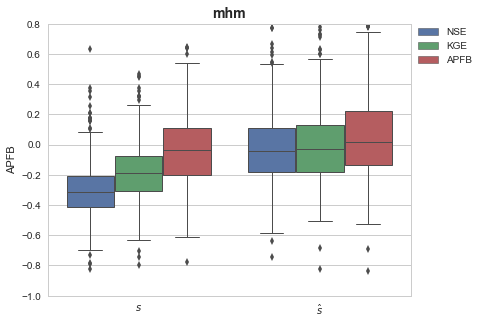

In [12]:
# Construct boxplots for annual peak bias group-by periods
model = 'mhm'
df_pbiasQpeak_val = pd.DataFrame(pbiasQpeak_val[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_pbiasQpeak_ens = pd.DataFrame(pbiasQpeak_ens[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_pbiasQpeak_val['Period'] = ['$s$' for _ in df_hcdn['id']]
df_pbiasQpeak_ens['Period'] = ['$\^s$' for _ in df_hcdn['id']]
df_pbiasQpeak = pd.concat([df_pbiasQpeak_val, df_pbiasQpeak_ens], axis=0)

dd_pbiasQpeak=pd.melt(df_pbiasQpeak, id_vars=['Period'], value_vars=obj_fun_list, var_name='OF')

plt.figure(figsize=(6.5,5))
sns.set_style("whitegrid")
ax11 = sns.boxplot(x='Period', y='value', data=dd_pbiasQpeak, hue='OF', linewidth=1.0)
handles, labels = ax11.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax11.set_ylabel('APFB')
ax11.set_ylim([-1.0,0.8])
ax11.set_xlabel('')
ax11.set_title('%s' % model, fontsize=14, fontweight='bold')
plt.savefig('../../Paper5_ffa/revision1/figure/pbiasQpeak.boxplot.ens.%s.png'%(model),
            format='png', 
            dpi=300,
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

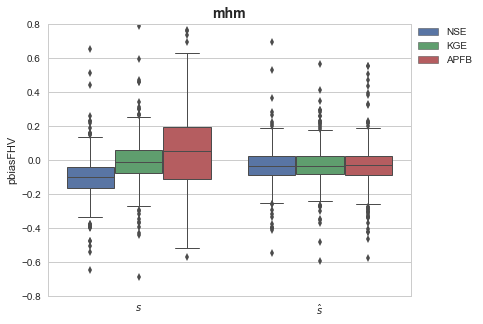

In [13]:
# percent bias for FHV - Construct boxplots for metrics group-by periods
model = 'mhm'
df_pbiasFHV_val = pd.DataFrame(pbiasFHV_val[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_pbiasFHV_ens = pd.DataFrame(pbiasFHV_ens[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_pbiasFHV_val['Period'] = ['$s$' for _ in df_hcdn['id']]
df_pbiasFHV_ens['Period'] = ['$\^s$' for _ in df_hcdn['id']]
df_pbiasFHV = pd.concat([df_pbiasFHV_val, df_pbiasFHV_ens], axis=0)

dd=pd.melt(df_pbiasFHV, id_vars=['Period'], value_vars=obj_fun_list, var_name='OF')

plt.figure(figsize=(6.5,5))
sns.set_style("whitegrid")
ax21 = sns.boxplot(x='Period', y='value', data=dd, hue='OF', linewidth=1.0)
handles, labels = ax21.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax21.set_ylim([-0.8,0.8])
ax21.set_xlabel('')
ax21.set_ylabel('pbiasFHV')
ax21.set_title('%s' % model, fontsize=14, fontweight='bold')
plt.savefig('../../Paper5_ffa/revision1/figure/pbiasFHV.boxplot.ens.%s.png' % (model),
            format='png', 
            dpi=300, 
#           bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

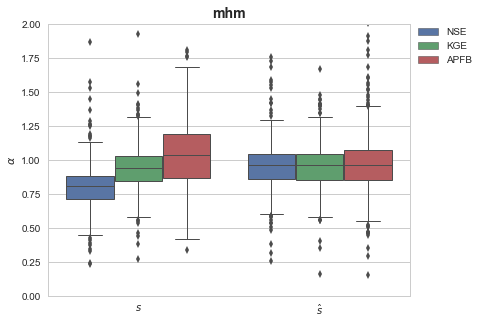

In [14]:
# percent bias for alpha - Construct boxplots for metrics group-by periods
model = 'mhm'
df_alpha_val = pd.DataFrame(alpha_val[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_alpha_ens = pd.DataFrame(alpha_ens[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_alpha_val['Period'] = ['$s$' for _ in df_hcdn['id']]
df_alpha_ens['Period'] = ['$\^s$' for _ in df_hcdn['id']]
df_alpha = pd.concat([df_alpha_val, df_alpha_ens], axis=0)

dd=pd.melt(df_alpha, id_vars=['Period'], value_vars=obj_fun_list, var_name='OF')

plt.figure(figsize=(6.5,5))

sns.set_style("whitegrid")
ax21 = sns.boxplot(x='Period', y='value', data=dd, hue='OF', linewidth=1.0)
handles, labels = ax21.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax21.set_ylim([0,2])
ax21.set_ylabel(r'$\alpha$')
ax21.set_xlabel('')
ax21.set_title('%s' % model, fontsize=14, fontweight='bold')
plt.savefig('../../Paper5_ffa/revision1/figure/alpha.boxplot.ens.%s.png' % (model),
            format='png', 
            dpi=300, 
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

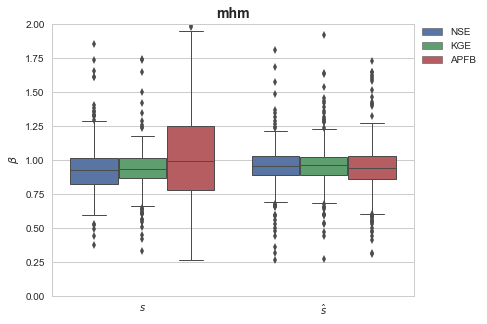

In [15]:
# percent bias for beta - Construct boxplots for metrics group-by periods
model = 'mhm'
df_beta_val = pd.DataFrame(beta_val[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_beta_ens = pd.DataFrame(beta_ens[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_beta_val['Period'] = ['$s$' for _ in df_hcdn['id']]
df_beta_ens['Period'] = ['$\^s$' for _ in df_hcdn['id']]
df_beta = pd.concat([df_beta_val, df_beta_ens], axis=0)

dd=pd.melt(df_beta, id_vars=['Period'], value_vars=obj_fun_list, var_name='OF')

plt.figure(figsize=(6.5,5))

sns.set_style("whitegrid")
ax21 = sns.boxplot(x='Period', y='value', data=dd, hue='OF', linewidth=1.0)
handles, labels = ax21.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax21.set_ylim([0,2])
ax21.set_ylabel(r'$\beta$')
ax21.set_xlabel('')
ax21.set_title('%s' % model, fontsize=14, fontweight='bold')
plt.savefig('../../Paper5_ffa/revision1/figure/beta.boxplot.ens.%s.png' % (model),
            format='png', 
            dpi=300, 
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

Text(0.5,1,u'vic')

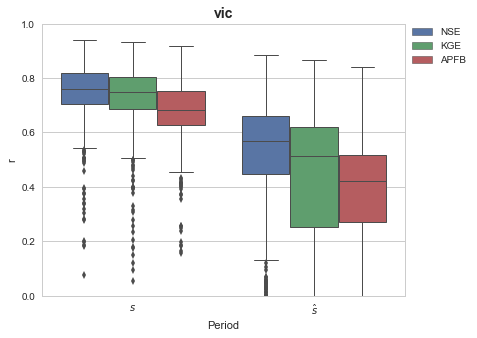

In [16]:
# correlation coefficient - Construct boxplots for metrics group-by periods
model = 'vic'
df_corr_val = pd.DataFrame(corr_val[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_corr_ens = pd.DataFrame(corr_ens[model], index=df_hcdn['id'], columns=obj_fun_list.keys())
df_corr_val['Period'] = ['$s$' for _ in df_hcdn['id']]
df_corr_ens['Period'] = ['$\^s$' for _ in df_hcdn['id']]
df_corr = pd.concat([df_corr_val, df_corr_ens], axis=0)

dd=pd.melt(df_corr, id_vars=['Period'], value_vars=obj_fun_list, var_name='OF')

plt.figure(figsize=(6.5,5))

sns.set_style("whitegrid")
ax21 = sns.boxplot(x='Period', y='value', data=dd, hue='OF', linewidth=1.0)
handles, labels = ax21.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax21.set_ylim([0,1])
ax21.set_ylabel('r')
ax21.set_title('%s' % model, fontsize=14, fontweight='bold')
#plt.savefig('../../Paper5_ffa/supple_figure/pbiasFHV.boxplot.%s.pdf' % (model),
#            format='pdf', 
#            dpi=300, 
#            bbox_extra_artists=(lgd,), 
#            bbox_inches='tight')

Text(0.5,1,u'vic')

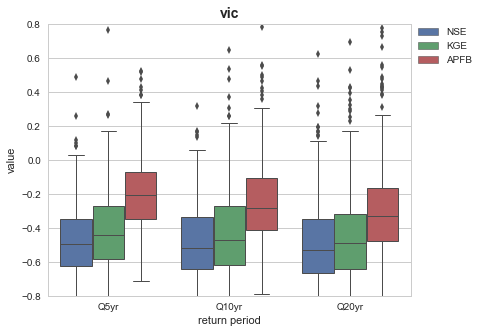

In [18]:
# Construct boxplots for flood magnitude bias at three return periods - gropu by return periods

# Not finished

model = 'vic'
df_pbiasQ20 = pd.DataFrame(pbiasQ20[model], index=df_hcdn['id'], columns=obj_fun_list)
df_pbiasQ10 = pd.DataFrame(pbiasQ10[model], index=df_hcdn['id'], columns=obj_fun_list)
df_pbiasQ5 = pd.DataFrame(pbiasQ5[model], index=df_hcdn['id'], columns=obj_fun_list)
df_pbiasQ20['return period'] = ['Q20yr' for _ in df_hcdn['id']]
df_pbiasQ10['return period'] = ['Q10yr' for _ in df_hcdn['id']]
df_pbiasQ5['return period'] = ['Q5yr' for _ in df_hcdn['id']]

df_pbiasQ = pd.concat([df_pbiasQ5, df_pbiasQ10, df_pbiasQ20], axis=0)

dd_Q = pd.melt(df_pbiasQ, id_vars=['return period'], value_vars=obj_fun_list, var_name='OF')

plt.figure(figsize=(6.5,5))
sns.set_style("whitegrid")
ax31 = sns.boxplot(x='return period', y='value', data=dd_Q, hue='OF', linewidth=1.0)
handles, labels = ax31.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax31.set_ylim([-0.8,0.8])
ax31.set_title('%s' % model, fontsize=14, fontweight='bold')
#plt.savefig('../../Paper5_ffa/supple_figure/pbiasQ.boxplot.%s.pdf' % (model),
#            format='pdf', 
#            dpi=300, 
#            bbox_extra_artists=(lgd,), 
#            bbox_inches='tight')